In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model # Import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.data import Dataset

In [3]:
DATASET_DIR = './dataset' # Directory containing the dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128 # Resize images to this size
IMAGE_CHANNELS = 3 # RGB
BATCH_SIZE = 32
EPOCHS = 20 # You might need more or less
LEARNING_RATE = 0.001

In [4]:
# --- MediaPipe Setup ---
mp_face_mesh = mp.solutions.face_mesh
NUM_LANDMARKS = 478 
NUM_LANDMARK_FEATURES = NUM_LANDMARKS * 2 # x, y for each landmark

In [5]:
def extract_landmarks(image_path):
    """Loads an image, extracts face landmarks using MediaPipe."""
    try:
        image = cv2.imread(image_path)
        if image is None:
            # print(f"Warning: Could not read image {image_path}") # Often noisy, uncomment if needed
            return None

        # Convert the BGR image to RGB.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image with MediaPipe Face Mesh
        # Ensure refine_landmarks=True matches the NUM_LANDMARKS = 478 setting
        with mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1) as face_mesh:
             results = face_mesh.process(image_rgb)

        # Extract landmarks
        if results.multi_face_landmarks:
            landmarks = []
            # We only expect one face (max_num_faces=1)
            # Check if the number of landmarks returned matches expectation before proceeding
            if len(results.multi_face_landmarks[0].landmark) != NUM_LANDMARKS:
                 # This check is still useful for images where MP might return a different number
                 # than the mode you configured (unlikely but possible edge cases)
                 print(f"Warning: MediaPipe returned {len(results.multi_face_landmarks[0].landmark)} landmarks for {image_path}, expected {NUM_LANDMARKS}.")
                 return None # Treat this as a detection failure for this sample

            for landmark in results.multi_face_landmarks[0].landmark:
                landmarks.append(landmark.x)
                landmarks.append(landmark.y)
                # Add z if needed and update NUM_LANDMARK_FEATURES accordingly
                # landmarks.append(landmark.z) # If you uncomment this, NUM_LANDMARK_FEATURES should be NUM_LANDMARKS * 3

            return np.array(landmarks, dtype=np.float32)
        else:
            # print(f"Warning: No face landmarks detected in {image_path}") # Often noisy, uncomment if needed
            return None # Indicate no landmarks found

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image (resize, normalize)."""
    try:
        img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        img_array = img_to_array(img)
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [6]:
# --- Generator Function (Corrected Yield Structure) ---
def data_generator_func(image_paths, labels):
    """
    Generator function to yield (image, landmarks), label tuples.
    Used with tf.data.Dataset.from_generator.
    Yields single samples, tf.data handles batching.
    """
    print(f"Generator started for {len(image_paths)} paths...") # Debug
    processed_count = 0
    for i, (img_path, label) in enumerate(zip(image_paths, labels)):
        # if i % 100 == 0 and i > 0: # Print progress every 100 samples after the start message
        #     print(f"Processing sample {i+1}/{len(image_paths)}")

        img_array = load_and_preprocess_image(img_path)
        landmark_data = extract_landmarks(img_path)

        # Skip sample if image failed to load OR landmark extraction failed (which now includes wrong count)
        if img_array is None or landmark_data is None:
             # print(f"Skipping sample {img_path} due to preprocessing error.") # Debug - uncomment if needed
             continue # Skip this sample

        # If we reach here, the sample is considered valid and has the correct shape
        processed_count += 1
        # --- FIX: Yield inputs as a TUPLE () instead of a LIST [] ---
        yield ((img_array, landmark_data), float(label)) # <<< Changed [img_array, landmark_data] to (img_array, landmark_data)

    print(f"Generator finished. Successfully processed {processed_count} samples.") # Debug


In [7]:
if __name__ == "__main__":
    print("Collecting data...")

    image_paths = []
    labels = []
    class_names = sorted(os.listdir(DATASET_DIR))

    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"Processing class: {class_name}")
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(class_name)

    if not image_paths:
        print(f"No images found in {DATASET_DIR}. Please check the path and structure.")
        exit()

    print(f"Found {len(image_paths)} images.")

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels) # 0 for one class, 1 for the other

    print(f"Classes: {label_encoder.classes_}")
    print(f"Encoded labels sample: {encoded_labels[:10]}")


    # Split data into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )

    print(f"Train samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")

    # --- Build the Model ---
    # Keep the model building part the same. The model definition is fine.
    # The issue was in how the data was fed to model.fit.

    # Input for Image
    image_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), name='image_input')

    # Image Branch (CNN)
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    image_features = Dense(128, activation='relu')(x)
    image_features = Dropout(0.5)(image_features)

    # Input for Landmarks (x, y for each landmark)
    landmark_input = Input(shape=(NUM_LANDMARK_FEATURES,), name='landmark_input')

    # Landmark Branch (Dense layers)
    y = Dense(64, activation='relu')(landmark_input)
    y = Dense(32, activation='relu')(y)
    y = Dropout(0.5)(y)
    landmark_features = Dense(16, activation='relu')(y)

    # Combine Features
    combined_features = concatenate([image_features, landmark_features])

    # Dense layers after combining
    z = Dense(64, activation='relu')(combined_features)
    z = Dropout(0.5)(z)

    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(z)

    # Create the model
    model = Model(inputs=[image_input, landmark_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # --- Create tf.data.Dataset from Generator Function ---
    # Define the output signature expected from data_generator_func for a single sample
    output_signature = (
        ( # Use a tuple for the inputs structure
            tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=tf.float32), # Image shape
            tf.TensorSpec(shape=(NUM_LANDMARK_FEATURES,), dtype=tf.float32) # Landmark shape (now 956)
        ),
        tf.TensorSpec(shape=(), dtype=tf.float32) # Label shape (scalar)
    )


Processing class: looking
Processing class: not_looking
Found 849 images.
Classes: ['looking' 'not_looking']
Encoded labels sample: [0 0 0 0 0 0 0 0 0 0]
Train samples: 679
Validation samples: 170


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ landmark_input      │ (None, 956)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     61,248 │ landmark_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,377,841 (12.89 MB)

 Trainable params: 3,377,841 (12.89 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_dataset = Dataset.from_generator(
    lambda: data_generator_func(train_paths, train_labels),
    output_signature=output_signature
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# Create the validation dataset
val_dataset = Dataset.from_generator(
    lambda: data_generator_func(val_paths, val_labels),
    output_signature=output_signature
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [120]:

# --- Debugging: Print Dataset Lengths (Still might be "unknown" but should process batches) ---
# Note: For tf.data.Dataset from generators, len() often isn't computable until iteration starts.
# The real test is whether model.fit starts processing steps.
try:
    # This might still print "unknown" if the generator is stateful or complex,
    # but the error in model.fit should be gone if samples are yielded.
    print(f"Approximate length of train_dataset (batches): {len(train_dataset) if hasattr(train_dataset, '__len__') else 'unknown'}")
except Exception as e:
    print(f"Could not determine exact length of train_dataset (expected if generator is complex): {e}")
try:
    print(f"Approximate length of val_dataset (batches): {len(val_dataset) if hasattr(val_dataset, '__len__') else 'unknown'}")
except Exception as e:
     print(f"Could not determine exact length of val_dataset (expected if generator is complex): {e}")
# --- Train the Model ---
print("\nTraining the model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)
print("Model training complete.")

Could not determine exact length of train_dataset (expected if generator is complex): The dataset length is unknown.
Could not determine exact length of val_dataset (expected if generator is complex): The dataset length is unknown.

Training the model...
Epoch 1/20
Generator started for 679 paths...
Generator finished. Successfully processed 676 samples.
     22/Unknown 32s 221ms/step - accuracy: 0.5405 - loss: 0.7637

c:\Users\jjona\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Generator started for 170 paths...
Generator finished. Successfully processed 168 samples.
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - accuracy: 0.5419 - loss: 0.7616 - val_accuracy: 0.6369 - val_loss: 0.6619
Epoch 2/20
Generator started for 679 paths...
Generator finished. Successfully processed 676 samples.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6099 - loss: 0.6757Generator started for 170 paths...
Generator finished. Successfully processed 168 samples.
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 528ms/step - accuracy: 0.6097 - loss: 0.6757 - val_accuracy: 0.6369 - val_loss: 0.6626
Epoch 3/20
Generator started for 679 paths...
Generator finished. Successfully processed 676 samples.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6358 - loss: 0.6605Generator started for 170 paths...
Generator finished. Successfully processed 168 samples.
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 523ms/step - accuracy: 0.6358 - loss: 0.6605 - val_accuracy: 0.6488 - val_loss: 0.6423
Epoch 4/20
Generator 

In [8]:
SAVED_MODEL_PATH = './saved_model.keras'

In [9]:
# --- Save the Model ---
print(f"\nSaving the model to {SAVED_MODEL_PATH}...")
# Use save('path/to/directory') for SavedModel format
model.save(SAVED_MODEL_PATH)
print("Model saved.")


Saving the model to ./saved_model.keras...
Model saved.


In [10]:
print("\n--- Phase 2: Loading Model and Making Prediction ---")

# Load the saved model
print(f"Loading model from {SAVED_MODEL_PATH}...")
loaded_model = load_model(SAVED_MODEL_PATH)
print("Model loaded successfully.")


--- Phase 2: Loading Model and Making Prediction ---
Loading model from ./saved_model.keras...
Model loaded successfully.


c:\Users\jjona\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
class_names_for_encoder = sorted(os.listdir(DATASET_DIR))
label_encoder_loaded = LabelEncoder()
# Need to fit the encoder on the known class names to map 0/1 back to strings
label_encoder_loaded.fit(class_names_for_encoder)
print(f"Recreated label encoder classes: {label_encoder_loaded.classes_}")
print(f"Recreated label mapping: {dict(zip(label_encoder_loaded.classes_, label_encoder_loaded.transform(label_encoder_loaded.classes_)))}")


Recreated label encoder classes: ['looking' 'not_looking']
Recreated label mapping: {'looking': 0, 'not_looking': 1}


In [12]:
def predict_looking(model, image_path, label_encoder):
    """
    Loads, preprocesses, and predicts the looking/not-looking class for a single image.

    Args:
        model: The trained TensorFlow model.
        image_path: Path to the input image file.
        label_encoder: The fitted LabelEncoder object.

    Returns:
        A tuple: (predicted_class_name, probability, success_status)
        success_status is True if prediction was made, False otherwise.
    """
    print(f"\nProcessing image for prediction: {image_path}")

    # Preprocess the image and extract landmarks
    img_array = load_and_preprocess_image(image_path)
    landmark_data = extract_landmarks(image_path)

    # Check if preprocessing was successful
    if img_array is None or landmark_data is None:
        print("  Prediction failed: Could not load image or detect face landmarks.")
        return ("Error", 0.0, False)

    # Check landmark count matches expected
    if landmark_data.shape[0] != NUM_LANDMARK_FEATURES:
         print(f"  Prediction failed: Unexpected number of landmarks ({landmark_data.shape[0]} != {NUM_LANDMARK_FEATURES}).")
         return ("Error", 0.0, False)


    # Add batch dimension (models expect inputs in batches, even for one sample)
    img_array = np.expand_dims(img_array, axis=0)
    landmark_data = np.expand_dims(landmark_data, axis=0)

    # Make prediction
    # model.predict expects a list of inputs for a multi-input model
    prediction_proba = model.predict([img_array, landmark_data])[0][0] # Get the single probability value

    # Determine the predicted class (0 or 1) based on probability
    predicted_class_encoded = (prediction_proba > 0.5).astype(int)

    # Inverse transform to get the class name
    predicted_class_name = label_encoder.inverse_transform([predicted_class_encoded])[0]

    print(f"  Prediction Probability: {prediction_proba:.4f}")
    print(f"  Predicted Class: {predicted_class_name}")

    return (predicted_class_name, prediction_proba, True)



Processing image for prediction: ./dataset\not_looking\000694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
  Prediction Probability: 0.5282
  Predicted Class: not_looking


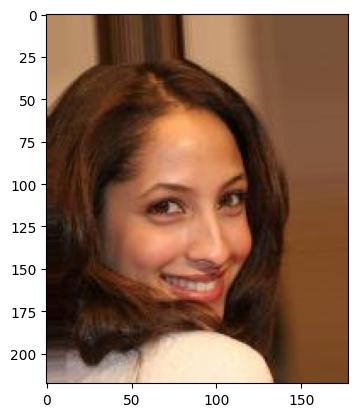

In [39]:
import matplotlib.pyplot as plt
if val_paths:
    random_index = np.random.randint(0, len(val_paths))
    example_image_for_prediction = val_paths[random_index] # Change this to a path to a new image file
    predict_looking(loaded_model, example_image_for_prediction, label_encoder_loaded)
    plt.imshow(cv2.cvtColor(cv2.imread(example_image_for_prediction), cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("No validation data available. Cannot perform example prediction.")

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import os # Needed for path joining and checking

# --- Configuration (Match your training script settings) ---
SAVED_MODEL_PATH = './saved_model.keras' # Path where you saved the model
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128 # Model's expected image input size
IMAGE_CHANNELS = 3 # RGB
NUM_LANDMARKS = 478 # Number of landmarks when refine_landmarks=True
NUM_LANDMARK_FEATURES = NUM_LANDMARKS * 2 # x, y for each landmark

# --- Load the Trained Model and Label Encoder ---
# Ensure the model and label encoder are available from your training phase
try:
    print(f"Loading model from {SAVED_MODEL_PATH}...")
    loaded_model = load_model(SAVED_MODEL_PATH)
    print("Model loaded successfully.")

    # Recreate the label encoder with the same classes and order as training
    # In a real-world scenario, you would save and load the LabelEncoder object
    # For this example, we'll assume the class names are the directory names
    # used during training, in sorted order.
    dataset_classes = sorted(os.listdir('./dataset')) # <<< Ensure this matches your DATASET_DIR from training
    label_encoder_loaded = LabelEncoder()
    label_encoder_loaded.fit(dataset_classes)
    print(f"Recreated label encoder classes: {label_encoder_loaded.classes_}")
    print(f"Label mapping: {dict(zip(label_encoder_loaded.classes_, label_encoder_loaded.transform(label_encoder_loaded.classes_)))}")

except Exception as e:
    print(f"Error loading model or label encoder: {e}")
    print("Please ensure the model is saved at the specified path and the dataset directory structure is correct.")
    exit() # Exit if model/encoder can't be loaded

# --- MediaPipe Setup ---
mp_face_mesh = mp.solutions.face_mesh
# Set static_image_mode=False for video stream processing
# max_num_faces=5 means it can detect up to 5 faces
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=5, refine_landmarks=True) # MUST match training refine_landmarks=True
drawing_utils = mp.solutions.drawing_utils
drawing_spec = drawing_utils.DrawingSpec(thickness=1, circle_radius=1)


# --- Helper Functions for Preprocessing a Single Frame/Face for the Model ---

def preprocess_frame_for_image_input(frame_np, target_size):
    """Resizes and normalizes a frame for the image input branch."""
    try:
        # Resize the frame
        resized_frame = cv2.resize(frame_np, (target_size[1], target_size[0])) # cv2.resize expects (width, height)
        # Convert to float32 and normalize to [0, 1]
        normalized_frame = resized_frame.astype(np.float32) / 255.0
        # Add batch dimension (1, H, W, C)
        img_input_processed = np.expand_dims(normalized_frame, axis=0)
        return img_input_processed
    except Exception as e:
        print(f"Error preprocessing image input: {e}")
        return None

def extract_and_flatten_landmarks(face_landmarks_mp, frame_width, frame_height):
    """
    Extracts, normalizes (implicitly by MediaPipe), and flattens ALL landmarks
    from a single MediaPipe face_landmarks object.
    """
    try:
        landmarks = []
        # Check if the number of landmarks returned matches expectation (478)
        if len(face_landmarks_mp.landmark) != NUM_LANDMARKS:
             print(f"Warning: MediaPipe returned {len(face_landmarks_mp.landmark)} landmarks, expected {NUM_LANDMARKS}. Skipping face.")
             return None # Return None if landmark count is unexpected

        for landmark in face_landmarks_mp.landmark:
            # MediaPipe provides normalized (x, y, z) coordinates relative to the frame size
            # We trained with normalized x, y, so we use them directly.
            # If your training used scaled coordinates (e.g., multiplied by width/height),
            # you would need to scale them here:
            # landmarks.append(landmark.x * frame_width)
            # landmarks.append(landmark.y * frame_height)
            landmarks.append(landmark.x)
            landmarks.append(landmark.y)
            # Add z if you used it in training and update NUM_LANDMARK_FEATURES
            # landmarks.append(landmark.z)

        # Flatten the list into a numpy array
        landmark_data = np.array(landmarks, dtype=np.float32)

        # Check the flattened shape
        if landmark_data.shape[0] != NUM_LANDMARK_FEATURES:
             # This check is technically redundant if len(face_landmarks_mp.landmark) was checked,
             # but adds robustness.
             print(f"Warning: Flattened landmarks shape {landmark_data.shape[0]} does not match expected {NUM_LANDMARK_FEATURES}. Skipping face.")
             return None


        # Add batch dimension (1, NUM_LANDMARK_FEATURES)
        landmark_input_processed = np.expand_dims(landmark_data, axis=0)

        return landmark_input_processed

    except Exception as e:
        print(f"Error extracting landmarks: {e}")
        return None


# --- Real-time Video Processing ---

cap = cv2.VideoCapture(0) # Use 0 for the default camera

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to read frame from camera. Exiting.")
        break

    # Get frame dimensions
    ih, iw = frame.shape[:2]

    # Convert the BGR frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe Face Mesh
    results = face_mesh.process(rgb_frame)

    # Prepare the full frame for the image input of the model (resized and normalized)
    # This assumes your training used the full resized image, not a cropped face region.
    # If you used cropped faces in training, you'd need to crop here per face.
    img_input_for_model = preprocess_frame_for_image_input(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Initialize a list to hold drawing information for each face
    face_drawing_info = []

    if results.multi_face_landmarks:
        # Loop through each detected face
        for face_landmarks_mp in results.multi_face_landmarks:

            # Extract and preprocess landmarks for this specific face
            landmark_input_for_model = extract_and_flatten_landmarks(face_landmarks_mp, iw, ih)

            # Check if both image and landmark inputs were successfully processed for the model
            if img_input_for_model is not None and landmark_input_for_model is not None:
                try:
                    # --- Perform Prediction using the loaded model ---
                    # The model expects inputs as a list: [image_batch, landmark_batch]
                    # We have batch size 1 for both here.
                    prediction_proba = loaded_model.predict([img_input_for_model, landmark_input_for_model], verbose=0)[0][0]

                    # Determine the predicted class (0 or 1)
                    predicted_class_encoded = (prediction_proba > 0.5).astype(int)

                    # Get the class name using the label encoder
                    predicted_label_name = label_encoder_loaded.inverse_transform([predicted_class_encoded])[0]

                    # Determine drawing color based on the prediction
                    label_color = (0, 255, 0) if predicted_label_name == 'looking' else (0, 0, 255) # Adjust 'looking' if your class name is different

                    # --- Get face location for drawing ---
                    # MediaPipe gives normalized coordinates. Find min/max x, y to approximate face bounding box.
                    x_coords = [lm.x for lm in face_landmarks_mp.landmark]
                    y_coords = [lm.y for lm in face_landmarks_mp.landmark]
                    min_x, max_x = int(min(x_coords) * iw), int(max(x_coords) * iw)
                    min_y, max_y = int(min(y_coords) * ih), int(max(y_coords) * ih)

                    # Store info for drawing later
                    face_drawing_info.append({
                        'label': predicted_label_name,
                        'proba': prediction_proba,
                        'color': label_color,
                        'coords_mp': face_landmarks_mp, # Keep MP object for mesh drawing
                        'bbox': (min_x, min_y, max_x, max_y) # Approximate bounding box
                    })

                except Exception as e:
                    print(f"Error during model prediction for a face: {e}")
                    # If prediction fails for a face, just skip drawing for it or draw a placeholder

    # --- Draw Results on the Frame ---

    # Draw MediaPipe face mesh and predicted label for each detected face
    for face_info in face_drawing_info:
        # Optional: Draw the face mesh landmarks (can be noisy in real-time)
        # drawing_utils.draw_landmarks(
        #     image=frame,
        #     landmark_list=face_info['coords_mp'],
        #     connections=mp_face_mesh.FACEMESH_TESSELATION, # Or FACEMESH_CONTOURS, FACEMESH_IRISES etc.
        #     landmark_drawing_spec=None, # Use default or custom spec
        #     connection_drawing_spec=drawing_spec # Use custom spec for connections
        # )

        # Draw prediction text near the face
        label = face_info['label']
        proba = face_info['proba']
        color = face_info['color']
        bbox = face_info['bbox']
        min_x, min_y, max_x, max_y = bbox

        # Position text near the top of the bounding box
        text_x = max(0, min_x)
        text_y = max(30, min_y - 10) # Position slightly above the face, ensure not negative

        cv2.putText(frame, f"{label} ({proba:.2f})", (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # Optional: Draw a rectangle around the detected face based on min/max landmarks
        # cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), color, 1)


    # Display the frame
    cv2.imshow("Face Looking Classifier", frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

Loading model from ./saved_model.keras...
Model loaded successfully.
Recreated label encoder classes: ['looking' 'not_looking']
Label mapping: {'looking': 0, 'not_looking': 1}


KeyboardInterrupt: 